In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
import scipy.stats as scs

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

In [2]:
dataset = pd.read_csv('T10Y2Y.csv',index_col=['DATE'], parse_dates=['DATE'])

In [3]:
dataset.head()

,T10Y2Y
DATE,
2017-08-08,0.93
2017-08-09,0.91
2017-08-10,0.87
2017-08-11,0.89
2017-08-14,0.89


In [4]:
dataset = dataset.loc[dataset['T10Y2Y'] != '.']
dataset['T10Y2Y']=dataset['T10Y2Y'].astype(float)

In [5]:
init_notebook_mode(connected = True)

In [6]:
def plot_df(df, title):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [7]:
plot_df(dataset, title='starting data')

In [8]:
def MA(series, n):
    mean = series.rolling(window=n).mean()
    std =  series.rolling(window=n).std()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(mean, "g", label="Rolling ma")
    plt.plot(std, "r", label="Rolling std")

    plt.plot(dataset[n:], label="values")
    plt.legend(loc="upper right")
    plt.grid(True)

In [9]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.T10Y2Y, 24)

-0.20916666666666664

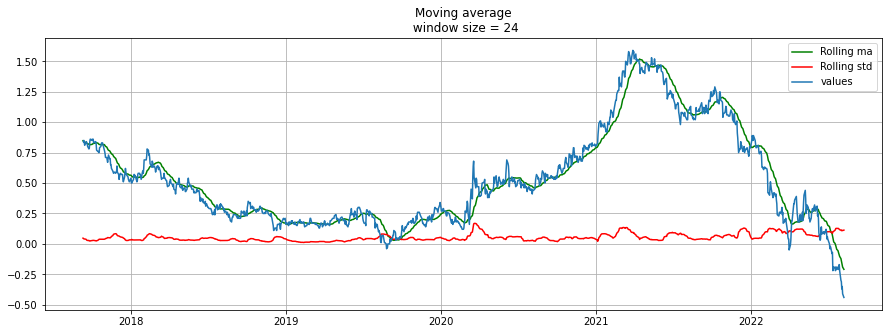

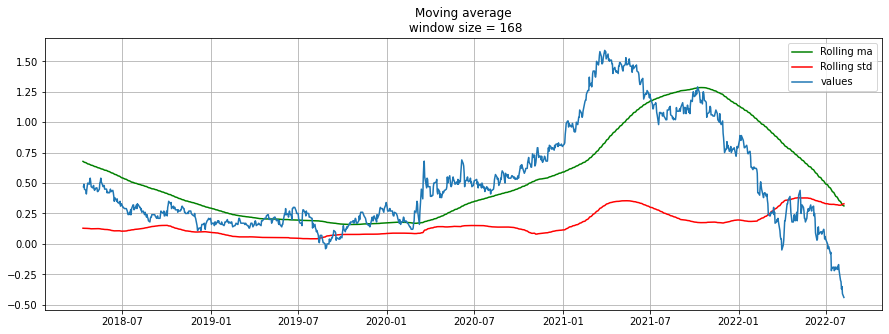

In [10]:
MA(dataset, 24) # сглаживаем по дням
MA(dataset, 24*7)

In [11]:
test = sm.tsa.adfuller(dataset)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: \n', test[4])
if test[0]> test[4]['5%']: 
    print ('non stacionar')
else:
    print ('stacionar')

adf:  -0.3562655040156415
p-value:  0.9171487833998662
Critical values: 
 {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
non stacionar


Dickey–Fuller test: p=0.917149


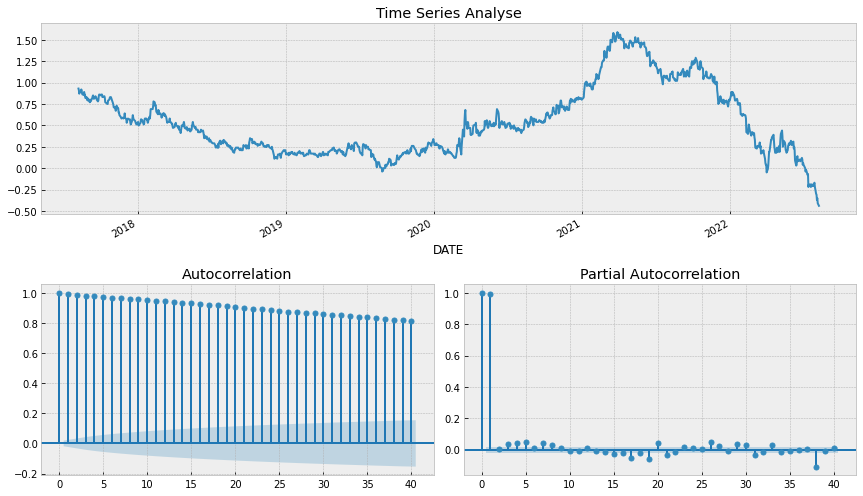

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analyse')
        smtsa.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smtsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.T10Y2Y, lags=40)

Dickey–Fuller test: p=0.958151
Optional box kox parametr: -0.204349


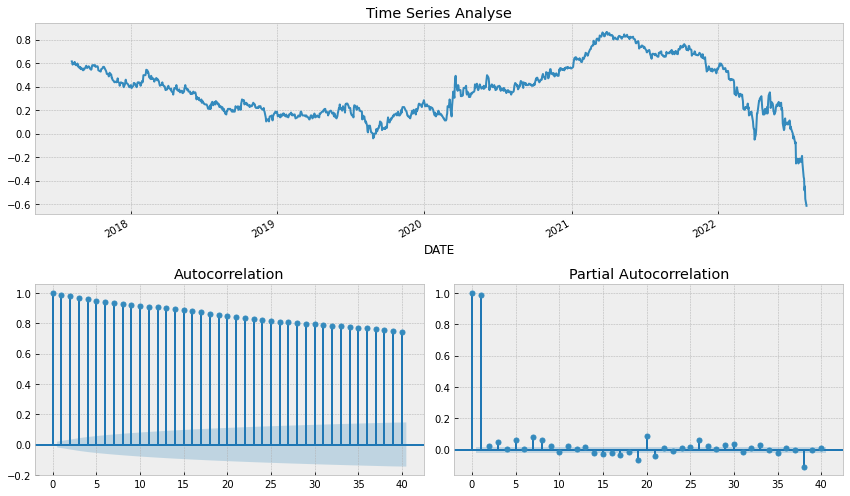

In [21]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['T10Y2Y_box'], lmbda = scs.boxcox(data.T10Y2Y + 1)
tsplot(data.T10Y2Y_box, lags=40)
print("Optional box kox parametr: %f" % lmbda)
#Критерий Дики-Фуллера стал только больше

Dickey–Fuller test: p=0.995449


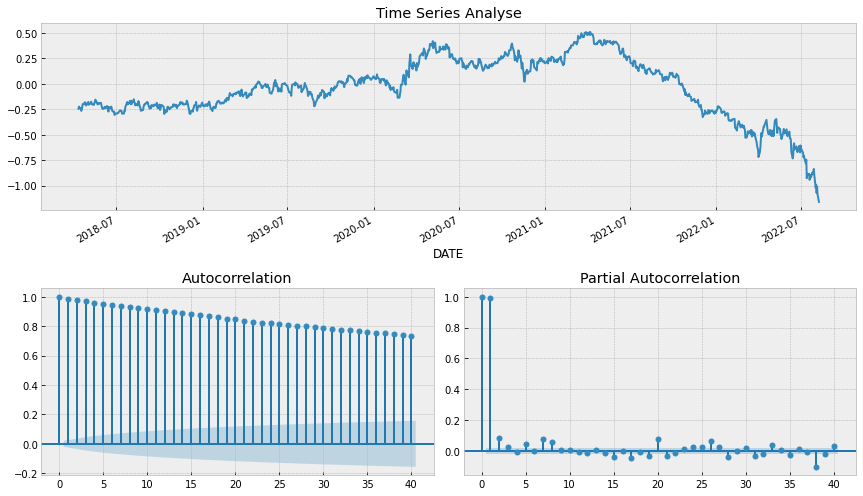

In [14]:
data['T10Y2Y_box_season'] = data.T10Y2Y_box - data.T10Y2Y_box.shift(24*7)
tsplot(data.T10Y2Y_box_season[24*7:], lags=40)

Dickey–Fuller test: p=0.000041


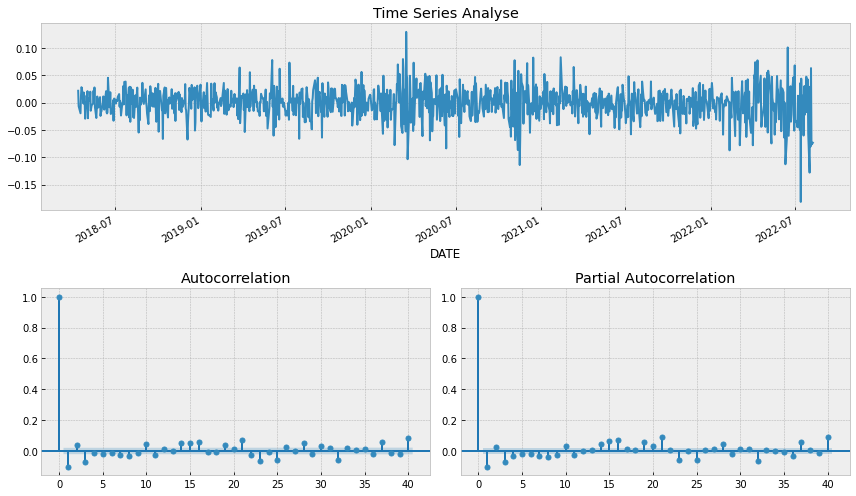

In [15]:
data['T10Y2Y_box_season_diff'] = data.T10Y2Y_box_season - data.T10Y2Y_box_season.shift(1)
tsplot(data.T10Y2Y_box_season_diff[24*7+1:], lags=40)

In [16]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

<AxesSubplot:xlabel='DATE'>

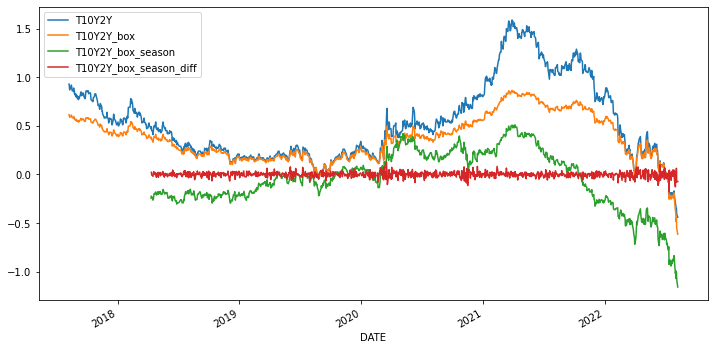

In [17]:
data.plot(figsize=(12,6))

In [18]:
data.index = pd.DatetimeIndex(data.index).to_period('D')

In [ ]:
"""%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(data.T10Y2Y_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    except ValueError:    
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())"""

  2%|▊                                       | 2/100 [05:47<5:28:15, 200.97s/it]

# kernel appears to die after 10 min of fitting.

In [26]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.T10Y2Y_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary())
# unfortinately coefficients for best_model are random

/Users/matulich/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matulich/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matulich/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                           T10Y2Y_box   No. Observations:                 1251
Model:             SARIMAX(4, 1, 3)x(4, 1, [1], 24)   Log Likelihood                2875.934
Date:                              Wed, 10 Aug 2022   AIC                          -5725.868
Time:                                      10:10:57   BIC                          -5659.418
Sample:                                           0   HQIC                         -5700.863
                                             - 1251                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0125      0.355      0.035      0.972      -0.684       0.709
ar.L2          0.36

/Users/matulich/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



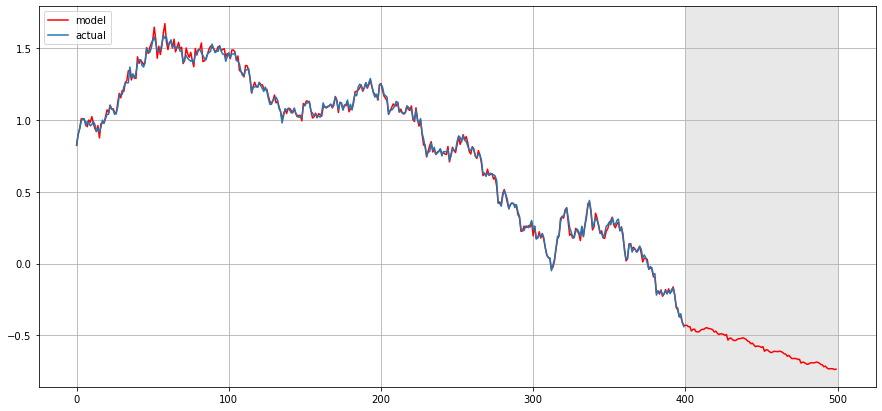

In [31]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:] - 1
actual = data.T10Y2Y.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
#plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().T10Y2Y, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)